In [1]:
from scipy.sparse.linalg import spsolve
from scipy.sparse import csc_matrix
from scipy.sparse import diags
import scipy.sparse as sparse
import scipy.linalg as linalg
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import mylib

$$\frac{d}{dx}\left(m_{uu}\frac{du}{dx}\right)+\frac{d}{dx}\left(m_{uv}\frac{dv}{dx}\right)=f_u\qquad x\in\,(0,L)$$
$$~$$
$$\frac{d}{dx}\left(m_{vu}\frac{du}{dx}\right)+\frac{d}{dx}\left(m_{vv}\frac{dv}{dx}\right)=f_v\qquad x\in\,(0,L)$$

{'type': 'dirichlet', 'value': 1.0}
{'type': 'dirichlet', 'value': 1.8193369910810597}
{'type': 'dirichlet', 'value': 1.0}
{'type': 'dirichlet', 'value': -2.75}
cond(Z) = 1976.695155997266
monolithic error = 2.5285604149310096e-12


/home/rob/projects/splittingschemes/python/mylib.py:175: LinAlgWarning: Ill-conditioned matrix (rcond=1.47221e-19): result may not be accurate.
  v = linalg.solve(


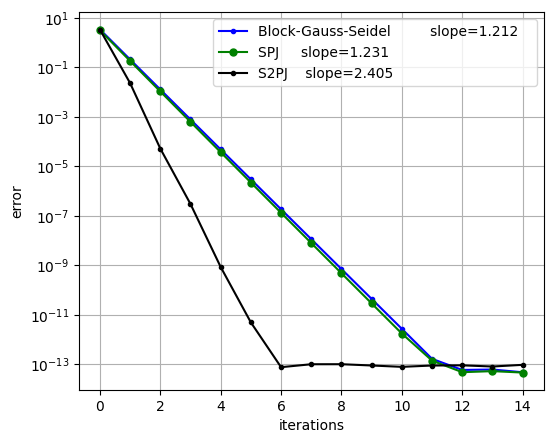

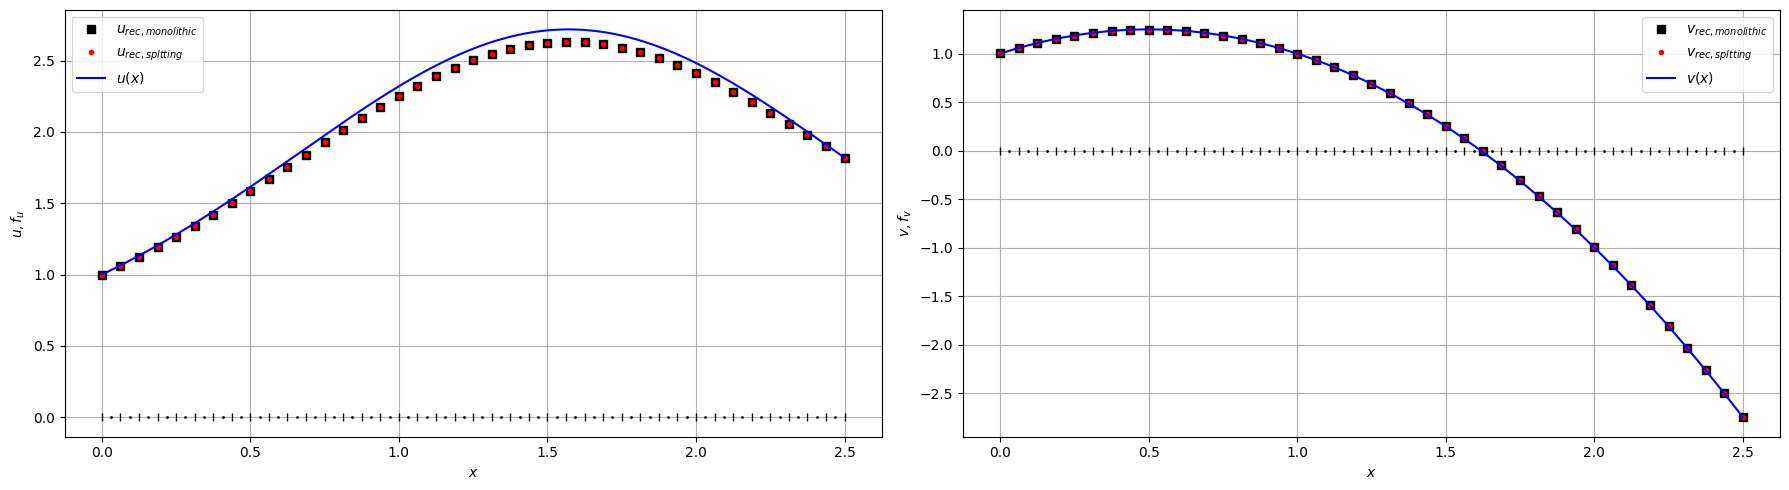

In [5]:
kwargs = {
    'a': 1.5,
    'b': 0.0,
    'c': 4.0,
    'd': 3.0,
    'e': 0.0,
    'f': 2.0
}

def fmuu(x, kwargs):
    return kwargs['a'] + kwargs['b']*np.sin(kwargs['c']*x)

def fmuv(x, kwargs):
    return 0.5 + 0.1*x

def fmvu(x, kwargs):
    return 0.5 - 0.05*x

def fmvv(x, kwargs):
    return kwargs['d'] + kwargs['e']*np.sin(kwargs['f']*x)

def sol_u(x, kwargs):
    return np.exp(np.sin(x))

def sol_v(x, kwargs):
    return 1.0 - np.square(x) + x

def f_u(x, kwargs):
    a = kwargs['a']
    b = kwargs['b']
    c = kwargs['c']
    d = kwargs['d']
    e = kwargs['e']
    f = kwargs['f']
    return np.exp(np.sin(x))*(b*c*np.cos(x)*np.cos(c*x)+(a+b*np.sin(c*x))*(np.square(np.cos(x))-np.sin(x))) -2.0*fmuv(x, kwargs)

def f_v(x, kwargs):
    a = kwargs['a']
    b = kwargs['b']
    c = kwargs['c']
    d = kwargs['d']
    e = kwargs['e']
    f = kwargs['f']
    return fmvu(x, kwargs)*(-np.sin(x)*np.exp(np.sin(x))+np.square(np.cos(x))*np.exp(np.sin(x))) + 2.0*(e*f*x*np.cos(f*x) - d - e*np.cos(f*x))

L = 2.5
N = 40
dx = np.divide(L, N)
x = np.linspace(0, L, N+1)
xc = np.linspace(0.5*dx, L-0.5*dx, N)
xfine = np.linspace(0, L, 1000)

leftBC_u = {
    'type':'dirichlet', #'type':'neumann',
    'value':sol_u(0.0, kwargs)}

rightBC_u = {
    'type':'dirichlet', #'type':'neumann',
    'value':sol_u(L, kwargs)}

leftBC_v = {
    'type':'dirichlet', #'type':'neumann',
    'value':sol_v(0.0, kwargs)}

rightBC_v = {
    'type':'dirichlet', #'type':'neumann',
    'value':sol_v(L, kwargs)}

print(leftBC_u)
print(rightBC_u)
print(leftBC_v)
print(rightBC_v)

A, fuuBC = mylib.fvm_laplacian_1D(fmuu, leftBC_u, rightBC_u, N, dx, L, kwargs)
B, fuvBC = mylib.fvm_laplacian_1D(fmuv, leftBC_v, rightBC_v, N, dx, L, kwargs)
C, fvuBC = mylib.fvm_laplacian_1D(fmvu, leftBC_u, rightBC_u, N, dx, L, kwargs)
D, fvvBC = mylib.fvm_laplacian_1D(fmvv, leftBC_v, rightBC_v, N, dx, L, kwargs)

fu = f_u(xc, kwargs) + fuuBC + fuvBC
fv = f_v(xc, kwargs) + fvuBC + fvvBC

A = A.toarray()
B = B.toarray()
C = C.toarray()
D = D.toarray()

Z = np.zeros((2*N,2*N))
Z[:N,:N] = A
Z[:N,N:] = B
Z[N:,:N] = C
Z[N:,N:] = D

f = np.concatenate((fu,fv))

sol = linalg.solve(Z, f)
u = sol[:N]
v = sol[N:]
u_rec = mylib.fvm_reconstruct_1D(u)
v_rec = mylib.fvm_reconstruct_1D(v)

omega = 1.0
nit = 15
u_BGS,  v_BGS,  res_BGS  = mylib.method_BlockGaussSeidel(A, B, C, D, fu, fv, nit, 0, sol)
u_SPJ,  v_SPJ,  res_SPJ  = mylib.method_ShurPartialJacobi(A, B, C, D, fu, fv, nit, 0, sol)
u_SPJ2, v_SPJ2, res_SPJ2 = mylib.method_ShurDualPartialJacobi(A, B, C, D, fu, fv, nit, sol)
u_INV,  v_INV,  res_INV  = mylib.method_ShurApproxinv(A, B, C, D, fu, fv, nit, sol, 10, epsilon=0.1)

print("cond(Z) =", np.linalg.cond(Z))
print(f"monolithic error = {np.linalg.norm(f-np.dot(Z,sol))}")

#####################################################################################################

plt.figure(dpi=100, figsize=(6,5))
nn = 5
plt.semilogy(res_BGS, 'b.-',  label=f"Block-Gauss-Seidel         slope={np.round(-mylib.slope(res_BGS[:nn]), 3)}   ")
plt.semilogy(res_SPJ, 'g.-',  label=f"SPJ     slope={np.round(-mylib.slope(res_SPJ[:nn]), 3)}", markersize=10)
plt.semilogy(res_SPJ2,'k.-',  label=f"S2PJ    slope={np.round(-mylib.slope(res_SPJ2[:nn]), 3)}")
#plt.semilogy(res_INV, 'c.-',  label=f"INV     slope={np.round(-mylib.slope(res_INV[:nn]), 3)}")
plt.legend()
plt.grid()
plt.xlabel('iterations')
plt.ylabel('error')
plt.savefig('error2.pdf')


fig, ax = plt.subplots(1, 2, figsize=(18,5), dpi=100)
markersize = 20
linewidth = 0.8
ax[0].set_xlabel(r'$x$')
ax[0].set_ylabel(r'$u,f_u$')
ax[0].plot(x, 0*x, '|', color='k', markersize=6.0)
ax[0].plot(xc, 0*xc, '.', color='k', markersize=2.0)
ax[0].plot(x, mylib.fvm_reconstruct_1D(u), 'sk' , label=r'$u_{rec,monolithic}$', linewidth=linewidth)
ax[0].plot(x, mylib.fvm_reconstruct_1D(u_SPJ), '.r' , label=r'$u_{rec,spltting}$', linewidth=linewidth)
#ax[0].plot(xc, u, '_y', label=r'$\frac{1}{|cell|}\int u\,dx$', markersize=markersize)
ax[0].plot(xfine, sol_u(xfine, kwargs), '-b', label=r'$u(x)$')
#ax[0].plot(xfine, m_u(xfine, kwargs), '--g', label=r'$m_u(x)$')
#ax[0].plot(xfine, f_u(xfine, kwargs), '--c', label=r'$f_u(x)$')
ax[0].legend()
ax[0].grid()

ax[1].set_xlabel(r'$x$')
ax[1].set_ylabel(r'$v,f_v$')
ax[1].plot(x, 0*x, '|', color='k', markersize=6.0)
ax[1].plot(xc, 0*xc, '.', color='k', markersize=2.0)
ax[1].plot(x, mylib.fvm_reconstruct_1D(v), 'sk' , label=r'$v_{rec,monolithic}$', linewidth=linewidth)
ax[1].plot(x, mylib.fvm_reconstruct_1D(v_SPJ), '.r' , label=r'$v_{rec,spltting}$', linewidth=linewidth)
#ax[1].plot(xc, v, '_y', label=r'$\frac{1}{|cell|}\int v\,dx$', markersize=markersize)
ax[1].plot(xfine, sol_v(xfine, kwargs), '-b', label=r'$v(x)$')
#ax[1].plot(xfine, m_v(xfine, kwargs), '--g', label=r'$m_v(x)$')
#ax[1].plot(xfine, f_v(xfine, kwargs), '--c', label=r'$f_v(x)$')
ax[1].legend()
ax[1].grid()

#ax[0].plot(x, mylib.fvm_reconstruct_1D(fTOT), '-g' , label='furec', linewidth=linewidth)
#ax[0].plot(xc, ff, '_g', label='ff', markersize=markersize)
#ax[0].set_ylim(bottom=-4, top=4)
#ax[1].set_ylim(bottom=-4, top=4)
#ax[0].set_xlim([-0.001,0.1])
plt.tight_layout()
plt.show()




